In [3]:
!pip install imblearn

In [17]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where,mean,std
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from pycm import ConfusionMatrix, Compare

In [18]:
df = pd.read_csv("data/processed/kaggle_transaction_dataset_centrality.csv")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20302 entries, 0 to 20301
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address                  20302 non-null  object 
 1   flag                     20302 non-null  int64  
 2   avgTimeBetweenSentTnx    20302 non-null  float64
 3   avgTimeBetweenRecTnx     20302 non-null  float64
 4   lifetime                 20302 non-null  float64
 5   sentTransactions         20302 non-null  int64  
 6   receivedTransactions     20302 non-null  int64  
 7   createdContracts         20302 non-null  int64  
 8   numUniqRecAddress        20302 non-null  int64  
 9   numUniqSentAddress       20302 non-null  int64  
 10  minValReceived           20302 non-null  float64
 11  maxValReceived           20302 non-null  float64
 12  avgValReceived           20302 non-null  float64
 13  minValSent               20302 non-null  float64
 14  maxValSent            

In [20]:
df.head()

,address,flag,avgTimeBetweenSentTnx,avgTimeBetweenRecTnx,lifetime,sentTransactions,receivedTransactions,createdContracts,numUniqRecAddress,numUniqSentAddress,...,maxValSent,avgValSent,totalTransactions,totalEtherSent,totalEtherReceived,totalEtherSentContracts,totalEtherBalance,degree_centrality,betweeness_centrality,eigenvector_centrality
0,0xd0cc2b24980cbcca47ef755da88b220a82291407,1,5.807655e+04,7.148260e+07,46.0,66,21,0,17,47,...,183.0,5.559412,87,366.92119,367.213130,0.0,0.291940,0.000690,0.000035,5.955279e-04
1,0x4cdc1cba0aeb5539f2e0ba158281e67e0e54a9b1,1,0.000000e+00,7.529115e+08,35.0,0,2,0,2,0,...,0.0,0.000000,2,0.00000,0.013541,0.0,0.013541,0.000000,0.000000,7.626269e-22
2,0x00e01a648ff41346cdeb873182383333d2184dd1,1,1.710279e+06,6.820612e+07,299.0,15,22,0,21,13,...,25.0,13.330000,37,199.95000,200.216494,0.0,0.266494,0.000099,0.000002,5.036766e-05
3,0x858457daa7e087ad74cdeeceab8419079bc2ca03,1,1.576106e+04,1.352571e+07,36.0,109,111,0,104,54,...,680.0,14.959358,220,1630.57000,1630.577419,0.0,0.007419,0.000788,0.000056,6.104170e-04
4,0x240e125c20a4cc84bd6e7f8d1fd07aff4c06d43d,1,0.000000e+00,3.751409e+08,82.0,1,4,0,4,1,...,1.9,1.900000,5,1.90000,1.902199,0.0,0.002199,0.000000,0.000000,1.065087e-19


In [21]:
df[df['address'].duplicated() == True]

,address,flag,avgTimeBetweenSentTnx,avgTimeBetweenRecTnx,lifetime,sentTransactions,receivedTransactions,createdContracts,numUniqRecAddress,numUniqSentAddress,...,maxValSent,avgValSent,totalTransactions,totalEtherSent,totalEtherReceived,totalEtherSentContracts,totalEtherBalance,degree_centrality,betweeness_centrality,eigenvector_centrality


In [22]:
# Train test split 

df_model = df.copy().drop(columns=['address'])

# split train and test set
X, y = df_model.drop(columns=['flag']), df_model['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
df_model['flag'].value_counts()

0    14627
1     5675
Name: flag, dtype: int64

In [24]:
# transform df by oversampling to combat imbalanced data
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

# summarise new class dist
counter = Counter(y_train_smote)
print(counter)

Counter({0: 9788, 1: 9788})


In [25]:
scaler = StandardScaler().fit(X_train_smote)
X_train_smote = scaler.transform(X_train_smote)
X_test =  scaler.transform(X_test)

In [10]:
# Logistic Regression with sag as solver

lr_model = LogisticRegression(max_iter=10000, solver="sag", random_state=42)

lr_model.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=10000, random_state=42, solver='sag')

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7246268656716418
Precision: 0.5023201856148491
Recall: 0.9306824288017195
F1-score: 0.6524769259747598
ROC AUC Score: 0.7880318529625461
              precision    recall  f1-score   support

           0       0.96      0.65      0.77      4839
           1       0.50      0.93      0.65      1861

    accuracy                           0.72      6700
   macro avg       0.73      0.79      0.71      6700
weighted avg       0.83      0.72      0.74      6700



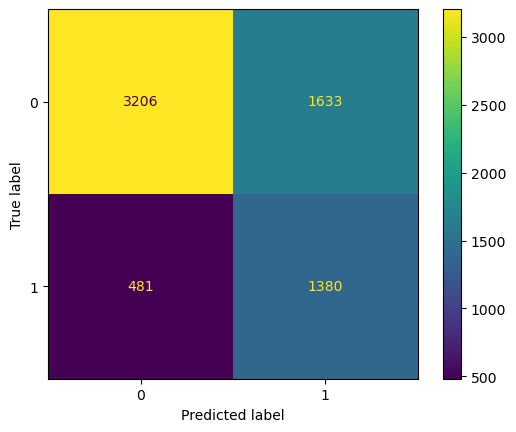

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)

disp.plot()
plt.show()

In [13]:
# Logistic Regression with lbfgs as solver

lr_model2 = LogisticRegression(max_iter=10000, random_state=42)

lr_model2.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=10000, random_state=42)

In [14]:
# Predict on test set
y_pred = lr_model2.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7077611940298507
Precision: 0.48030856678846934
Recall: 0.6356797420741537
F1-score: 0.5471785383903793
ROC AUC Score: 0.6855811398942788
              precision    recall  f1-score   support

           0       0.84      0.74      0.78      4839
           1       0.48      0.64      0.55      1861

    accuracy                           0.71      6700
   macro avg       0.66      0.69      0.67      6700
weighted avg       0.74      0.71      0.72      6700



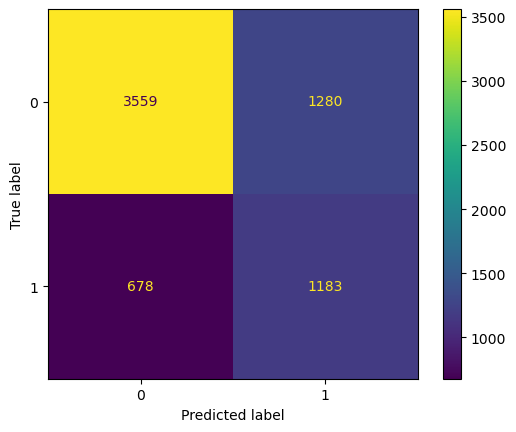

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=lr_model2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model2.classes_)

disp.plot()
plt.show()

In [75]:
# params of LR
C = np.logspace(-4, 4, 50)

params = {'C':C}

In [76]:

from sklearn.model_selection import GridSearchCV

model = LogisticRegression(random_state=42)
clf = GridSearchCV(model, params,cv=10, scoring='f1')

clf.fit(X_train_smote, y_train_smote)

c:\Users\turtl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\turtl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362...
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])},
             scoring='f1')

In [80]:

print(clf.best_params_)

{'C': 1048.1131341546852}


In [26]:
# Support vector machine
svm_model  =SVC(random_state=42)

svm_model.fit(X_train_smote, y_train_smote)

SVC(random_state=42)

In [27]:
# Predict on test set
y_pred = svm_model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7204477611940299
Precision: 0.4972652689152233
Recall: 0.5862439548629769
F1-score: 0.5381011097410604
ROC AUC Score: 0.6791521489545304
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      4839
           1       0.50      0.59      0.54      1861

    accuracy                           0.72      6700
   macro avg       0.66      0.68      0.67      6700
weighted avg       0.74      0.72      0.73      6700



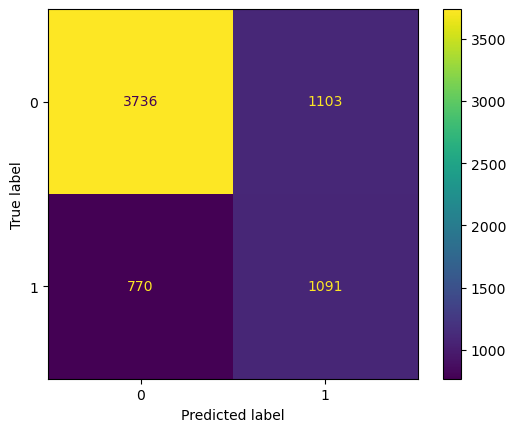

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

disp.plot()
plt.show()

In [16]:
#Random forest model
rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(criterion='entropy', n_estimators=150)

In [17]:
# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9565671641791045
Precision: 0.922497308934338
Recall: 0.9210102095647501
F1-score: 0.9217531594514654
ROC AUC Score: 0.9456259975288103
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4839
           1       0.92      0.92      0.92      1861

    accuracy                           0.96      6700
   macro avg       0.95      0.95      0.95      6700
weighted avg       0.96      0.96      0.96      6700



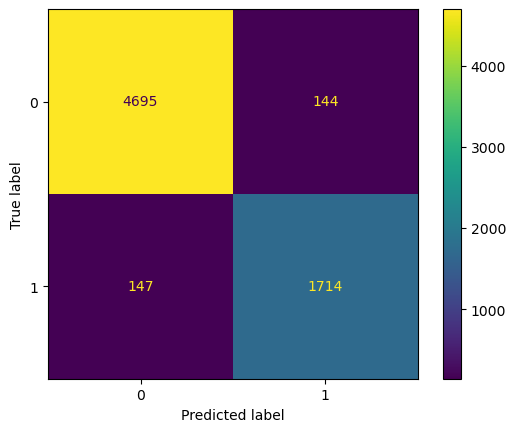

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

disp.plot()
plt.show()

In [32]:
#tuned RF model

from sklearn.model_selection import GridSearchCV

# Define RANDOM_STATE
RANDOM_STATE = 42

# Define hyperparameter grid for the Random Forest
param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_smote, y_train_smote)
best_rf_params = grid_search.best_params_
tuned_rf_model = RandomForestClassifier(**best_rf_params)

print("Best parameters for RF model:",best_rf_params )

Best parameters for RF model: {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 150}


In [33]:
# Fit the tuned RF model to the training data
tuned_rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = tuned_rf_model.predict(X_test)

# Evaluate the model performance
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9556716417910448
Precision: 0.9240780911062907
Recall: 0.9156367544331004
F1-score: 0.9198380566801618
ROC AUC Score: 0.9433525784978067
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4839
           1       0.92      0.92      0.92      1861

    accuracy                           0.96      6700
   macro avg       0.95      0.94      0.94      6700
weighted avg       0.96      0.96      0.96      6700



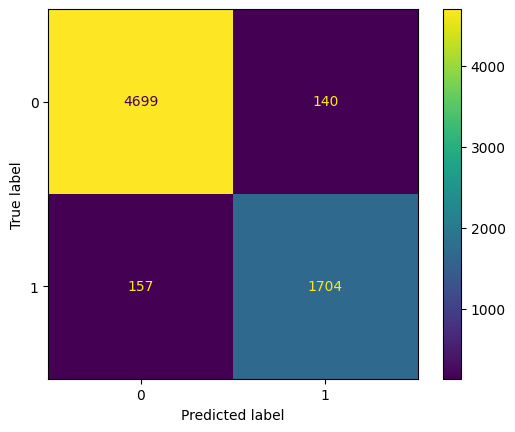

In [34]:
# Confusion Matrix for tuned RF model

cm = confusion_matrix(y_test, y_pred, labels=tuned_rf_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_rf_model.classes_)

disp.plot()
plt.show()

In [26]:
# Define the XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)

xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9653731343283583
Precision: 0.940032414910859
Recall: 0.9349811929070392
F1-score: 0.9374999999999999
ROC AUC Score: 0.9560212846122301
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4839
           1       0.94      0.93      0.94      1861

    accuracy                           0.97      6700
   macro avg       0.96      0.96      0.96      6700
weighted avg       0.97      0.97      0.97      6700



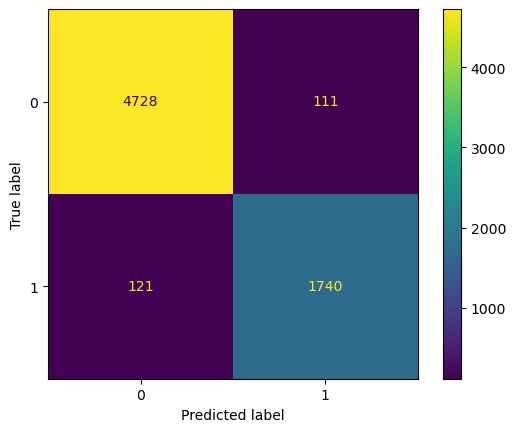

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=xgb_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)

disp.plot()
plt.show()

In [29]:
# improving the XGB model with grid search

from sklearn.model_selection import GridSearchCV
# define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}
# Define the XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', random_state=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.6s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.7s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.7s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.7s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   5.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   5.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   5.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   5.4s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   5.3s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   4.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=300; total time=   8.0s
[CV] END ..learning_rate=0.0

In [30]:
# Define the XGBoost model with the best parameters
xgb_model_tuned = XGBClassifier(objective='binary:logistic', random_state=1)
xgb_model_tuned.set_params(**grid_search.best_params_)

# Fit the model to the training data
xgb_model_tuned.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = xgb_model_tuned.predict(X_test)

# Evaluate the model performance
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9677611940298507
Precision: 0.9467680608365019
Recall: 0.9365932294465341
F1-score: 0.9416531604538086
ROC AUC Score: 0.9581705556201465
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4839
           1       0.95      0.94      0.94      1861

    accuracy                           0.97      6700
   macro avg       0.96      0.96      0.96      6700
weighted avg       0.97      0.97      0.97      6700



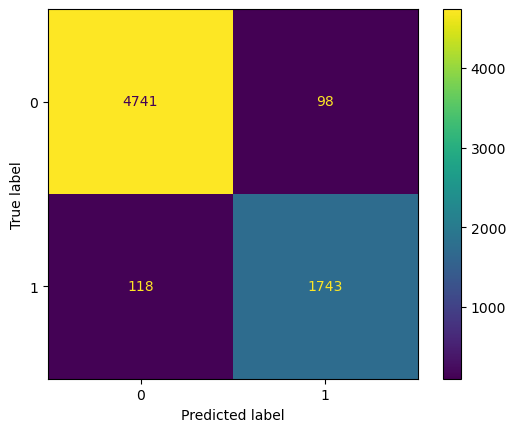

In [31]:
cm = confusion_matrix(y_test, y_pred, labels=xgb_model_tuned.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_tuned.classes_)

disp.plot()
plt.show()

In [12]:
#KNN model

knn_params = {"n_neighbors": 15}

knn_model = KNeighborsClassifier(**knn_params)


knn_model.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(n_neighbors=15)

In [18]:
# Make predictions on the test data
y_pred = knn_model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9246268656716418
Precision: 0.8434650455927052
Recall: 0.8946802794196669
F1-score: 0.8683181225554109
ROC AUC Score: 0.9154120553948923
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4839
           1       0.84      0.89      0.87      1861

    accuracy                           0.92      6700
   macro avg       0.90      0.92      0.91      6700
weighted avg       0.93      0.92      0.93      6700



In [21]:
#Shapley values for KNN model

import shap

subset_size = 1000 

# Randomly select a subset 
subset_indices = np.random.choice(X.shape[0], subset_size, replace=False)
X_subset = X.iloc[subset_indices]
y_subset = y.iloc[subset_indices]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
knn_model.fit(X_scaled, y)

# Calculate Shapley values
explainer = shap.KernelExplainer(knn_model.predict, shap.sample(X_scaled, 20))
shap_values = explainer.shap_values(X_subset)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
#Shapley values for XGBOOST model(tuned)

xgb_model_tuned.fit(X_scaled, y)

# Calculate Shapley values
xgb_explainer = shap.KernelExplainer(xgb_model_tuned.predict, shap.sample(X_scaled, 20))
xgb_shap_values = xgb_explainer.shap_values(X_subset)


  0%|          | 0/1000 [00:00<?, ?it/s]

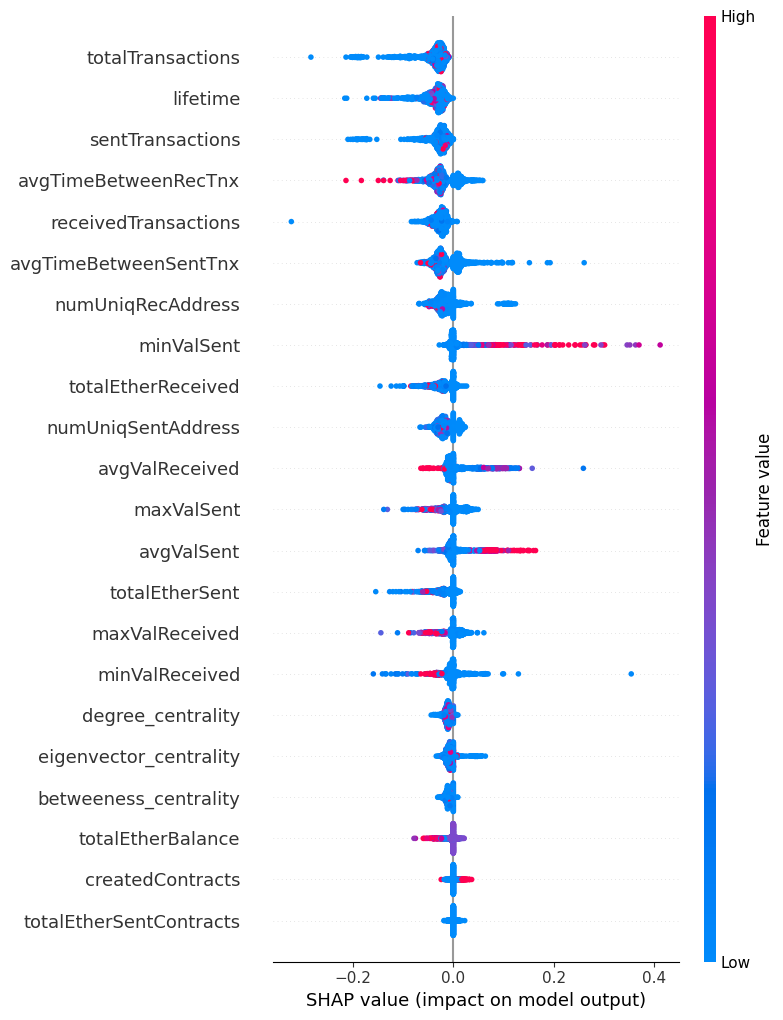

In [26]:
#Shapley values for KNN model
import shap
import matplotlib.pyplot as plt

feature_names = X.columns
# Summary Plot for Feature Importance
shap.summary_plot(shap_values, X_subset, feature_names=feature_names,max_display=30)
plt.show()

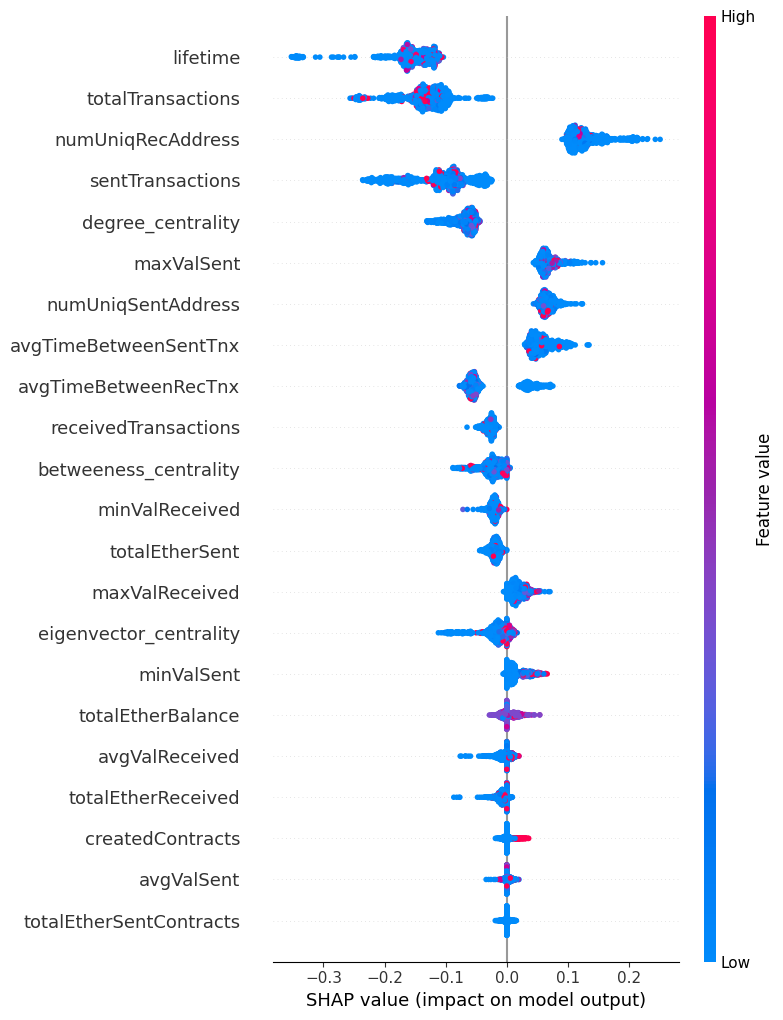

In [29]:
#Shapley values for XGBoost(tuned) model
import shap
import matplotlib.pyplot as plt

feature_names = X.columns
# Summary Plot for Feature Importance
shap.summary_plot(xgb_shap_values, X_subset, feature_names=feature_names,max_display=30)
plt.show()

In [27]:
#Shapley values for KNN model
feature_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

for feature_index in feature_indices:
    feature_name = feature_names[feature_index]

    feature_shap_values = shap_values[:, feature_index]

    positive_impact_count = sum(feature_shap_values > 0)
    negative_impact_count = sum(feature_shap_values < 0)

    print(f"Feature: {feature_name}")
    print(f"Number of Samples with Positive Impact: {positive_impact_count}")
    print(f"Number of Samples with Negative Impact: {negative_impact_count}")

Feature: avgTimeBetweenSentTnx
Number of Samples with Positive Impact: 321
Number of Samples with Negative Impact: 638
Feature: avgTimeBetweenRecTnx
Number of Samples with Positive Impact: 204
Number of Samples with Negative Impact: 766
Feature: lifetime
Number of Samples with Positive Impact: 0
Number of Samples with Negative Impact: 999
Feature: sentTransactions
Number of Samples with Positive Impact: 0
Number of Samples with Negative Impact: 996
Feature: receivedTransactions
Number of Samples with Positive Impact: 2
Number of Samples with Negative Impact: 996
Feature: createdContracts
Number of Samples with Positive Impact: 304
Number of Samples with Negative Impact: 336
Feature: numUniqRecAddress
Number of Samples with Positive Impact: 106
Number of Samples with Negative Impact: 823
Feature: numUniqSentAddress
Number of Samples with Positive Impact: 163
Number of Samples with Negative Impact: 797
Feature: minValReceived
Number of Samples with Positive Impact: 169
Number of Samples 

In [30]:
#Shapley values for XGBoost(tuned) model
feature_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

for feature_index in feature_indices:
    feature_name = feature_names[feature_index]

    feature_shap_values = xgb_shap_values[:, feature_index]

    positive_impact_count = sum(feature_shap_values > 0)
    negative_impact_count = sum(feature_shap_values < 0)

    print(f"Feature: {feature_name}")
    print(f"Number of Samples with Positive Impact: {positive_impact_count}")
    print(f"Number of Samples with Negative Impact: {negative_impact_count}")

Feature: avgTimeBetweenSentTnx
Number of Samples with Positive Impact: 1000
Number of Samples with Negative Impact: 0
Feature: avgTimeBetweenRecTnx
Number of Samples with Positive Impact: 263
Number of Samples with Negative Impact: 737
Feature: lifetime
Number of Samples with Positive Impact: 0
Number of Samples with Negative Impact: 1000
Feature: sentTransactions
Number of Samples with Positive Impact: 0
Number of Samples with Negative Impact: 1000
Feature: receivedTransactions
Number of Samples with Positive Impact: 0
Number of Samples with Negative Impact: 1000
Feature: createdContracts
Number of Samples with Positive Impact: 372
Number of Samples with Negative Impact: 369
Feature: numUniqRecAddress
Number of Samples with Positive Impact: 1000
Number of Samples with Negative Impact: 0
Feature: numUniqSentAddress
Number of Samples with Positive Impact: 1000
Number of Samples with Negative Impact: 0
Feature: minValReceived
Number of Samples with Positive Impact: 0
Number of Samples wi

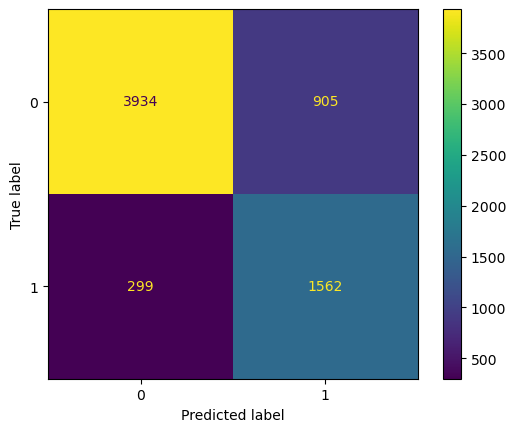

In [32]:
cm = confusion_matrix(y_test, y_pred, labels=knn_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)

disp.plot()
plt.show()

In [37]:
# Neural network model

nn_params = {"hidden_layer_sizes": (100, 100), "solver": "adam"}

nn_model = MLPClassifier(**nn_params)
nn_model.fit(X_train_smote, y_train_smote)

MLPClassifier(hidden_layer_sizes=(100, 100))

In [38]:
# Make predictions on the test data
y_pred = nn_model.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9435820895522388
Precision: 0.9014618299945858
Recall: 0.8946802794196669
F1-score: 0.8980582524271845
ROC AUC Score: 0.9285346013754668
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4839
           1       0.90      0.89      0.90      1861

    accuracy                           0.94      6700
   macro avg       0.93      0.93      0.93      6700
weighted avg       0.94      0.94      0.94      6700



Implementing Graph methods

In [43]:
# Combining both accounts data and queried data
merged_df = pd.DataFrame()
i = 0
while True:
    try:
        df = pd.read_csv(f'data/queried/transactions_{i}.csv')
        merged_df = pd.concat([merged_df, df])
        i += 1
    except:
        merged_df.to_csv('data/queried/full_transactions.csv', index=False)
        break

C:\Users\turtl\AppData\Local\Temp\ipykernel_16412\2724656135.py:5: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'data/queried/transactions_{i}.csv')
C:\Users\turtl\AppData\Local\Temp\ipykernel_16412\2724656135.py:5: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'data/queried/transactions_{i}.csv')


In [44]:
# Graph methods
!pip install torch
!pip install torch_geometric

import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.data import Data

account_df = pd.read_csv('data/processed/kaggle_transaction_dataset_centrality.csv')
address_mapping = pd.DataFrame(data={
    'address': account_df['address'], 
    'mapped_id': account_df['address'].index
})

transaction_df = pd.read_csv('data/queried/full_transactions.csv')
transaction_mapping = transaction_df \
    .merge(
        address_mapping, 
        left_on='address from', 
        right_on='address'
    ) \
    .merge(
        address_mapping, 
        left_on='address to', 
        right_on='address', 
        suffixes=('_from', '_to')
    )

x = F.normalize(
    torch.tensor(
        account_df.drop(columns=['address', 'flag']).to_numpy(), 
        dtype=torch.float
    )
)
y = torch.tensor(
    account_df['flag'].to_numpy(), 
    dtype=torch.long
)
edge_index = torch.tensor(
    transaction_mapping[['mapped_id_from', 'mapped_id_to']].to_numpy().T, 
    dtype=torch.long
)

data = Data(x=x, y=y, edge_index=edge_index)
data = T.ToUndirected()(data)
data = T.RandomNodeSplit(num_val=0, num_test=2000)(data)
data

Data(x=[20302, 22], edge_index=[2, 197481], y=[20302], train_mask=[20302], val_mask=[20302], test_mask=[20302])

In [47]:
classes, counts = torch.unique(y, return_counts=True)

# Calculate class weights based on their frequency
total_samples = torch.sum(counts).float()
class_weights = total_samples / (classes.numel() * counts.float())

print("Class Weights:", class_weights)

Class Weights: tensor([0.6940, 1.7887])


In [48]:
from torch_geometric.nn import GATConv, GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, heads=4):
        super().__init__()
        self.conv1 = GATConv(data.num_node_features, 32, heads=heads)
        self.conv2 = GATConv(32 * heads, 32, heads=heads)
        self.conv3 = GATConv(32 * heads, 2, heads=1)  # Last layer typically uses a single head

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)

In [49]:
def get_results(model, data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(251):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=class_weights)
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            pred = model(data).argmax(dim=1)
            correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
            acc = int(correct) / int(data.test_mask.sum())
            precision = precision_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
            recall = recall_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
            f1 = f1_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
            auroc = roc_auc_score(data.y[data.test_mask], pred[data.test_mask])
            print(f'Epoch {str(epoch).zfill(3)}: Accuracy {acc:.3f} Precision: {precision:.3f} Recall: {recall:.3f} F1 Score {f1:.3f} AUROC: {auroc:.3f}')
    return model

In [50]:
get_results(GCN(), data)

Epoch 000: Accuracy 0.603 Precision: 0.741 Recall: 0.603 F1 Score 0.623 AUROC: 0.662
Epoch 010: Accuracy 0.777 Precision: 0.804 Recall: 0.777 F1 Score 0.786 AUROC: 0.766
Epoch 020: Accuracy 0.843 Precision: 0.857 Recall: 0.843 F1 Score 0.847 AUROC: 0.833
Epoch 030: Accuracy 0.870 Precision: 0.874 Recall: 0.870 F1 Score 0.871 AUROC: 0.849
Epoch 040: Accuracy 0.873 Precision: 0.882 Recall: 0.873 F1 Score 0.875 AUROC: 0.864
Epoch 050: Accuracy 0.876 Precision: 0.883 Recall: 0.876 F1 Score 0.878 AUROC: 0.863
Epoch 060: Accuracy 0.872 Precision: 0.881 Recall: 0.872 F1 Score 0.874 AUROC: 0.864
Epoch 070: Accuracy 0.877 Precision: 0.885 Recall: 0.877 F1 Score 0.880 AUROC: 0.866
Epoch 080: Accuracy 0.877 Precision: 0.888 Recall: 0.877 F1 Score 0.881 AUROC: 0.874
Epoch 090: Accuracy 0.876 Precision: 0.885 Recall: 0.876 F1 Score 0.879 AUROC: 0.868
Epoch 100: Accuracy 0.882 Precision: 0.893 Recall: 0.882 F1 Score 0.885 AUROC: 0.881
Epoch 110: Accuracy 0.886 Precision: 0.892 Recall: 0.886 F1 Score

GCN(
  (conv1): GCNConv(22, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 2)
)

In [51]:
get_results(GAT(), data)

Epoch 000: Accuracy 0.757 Precision: 0.750 Recall: 0.757 F1 Score 0.753 AUROC: 0.677
Epoch 010: Accuracy 0.790 Precision: 0.823 Recall: 0.790 F1 Score 0.799 AUROC: 0.792
Epoch 020: Accuracy 0.857 Precision: 0.858 Recall: 0.857 F1 Score 0.858 AUROC: 0.823
Epoch 030: Accuracy 0.879 Precision: 0.879 Recall: 0.879 F1 Score 0.879 AUROC: 0.844
Epoch 040: Accuracy 0.879 Precision: 0.884 Recall: 0.879 F1 Score 0.881 AUROC: 0.863
Epoch 050: Accuracy 0.860 Precision: 0.876 Recall: 0.860 F1 Score 0.864 AUROC: 0.860
Epoch 060: Accuracy 0.896 Precision: 0.899 Recall: 0.896 F1 Score 0.898 AUROC: 0.880
Epoch 070: Accuracy 0.883 Precision: 0.887 Recall: 0.883 F1 Score 0.885 AUROC: 0.864
Epoch 080: Accuracy 0.902 Precision: 0.903 Recall: 0.902 F1 Score 0.903 AUROC: 0.877
Epoch 090: Accuracy 0.889 Precision: 0.901 Recall: 0.889 F1 Score 0.892 AUROC: 0.892
Epoch 100: Accuracy 0.913 Precision: 0.913 Recall: 0.913 F1 Score 0.913 AUROC: 0.889
Epoch 110: Accuracy 0.893 Precision: 0.897 Recall: 0.893 F1 Score

GAT(
  (conv1): GATConv(22, 32, heads=4)
  (conv2): GATConv(128, 32, heads=4)
  (conv3): GATConv(128, 2, heads=1)
)